In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
import statistics
import operator
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures2.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,NaN,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
453537,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,NaN,1,100.0,0,0.0,0,0.0,0,0.0
453538,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
453539,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
453540,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0


## Data validation

#### NaN counts

In [3]:
print(df.isna().sum(),'\n')
print(df.isna().sum().sum())

source                      0
service                     0
timestamp_dir               0
timestamp_site          24646
operational_count           0
operational_pct            82
partial_outage_count        0
partial_pct                82
major_outage_count          0
major_pct                  82
maint_count                 0
maint_pct                  82
dtype: int64 

24974


#### Find rows with NaN (not including timestamp_site)

In [4]:
df_tmp = df.copy()
df_tmp.drop(['timestamp_site'], axis=1, inplace=True)
is_nan = df_tmp.isnull()
row_has_nan = is_nan.any(axis=1)
nan_rows = df[row_has_nan]
nan_rows

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
150954,downrightnow,netflix,2018-12-15 05:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
152821,downrightnow,hotmail,2018-12-20 02:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
152895,downrightnow,hotmail,2018-12-20 06:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
154079,downrightnow,facebook,2018-12-23 08:00:02,9,0,NaN,0,NaN,0,NaN,0,NaN
155012,downrightnow,youtube,2018-12-25 19:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
288895,downrightnow,gmail,2019-12-09 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
295188,downrightnow,linkedin,2019-12-25 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
295810,downrightnow,youtube,2019-12-27 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
296328,downrightnow,gmail,2019-12-28 19:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN


#### Drop timestamp_site and remaining rows with NaN

In [5]:
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)
df

,source,service,timestamp_dir,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
453537,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,1,100.0,0,0.0,0,0.0,0,0.0
453538,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,1,100.0,0,0.0,0,0.0,0,0.0
453539,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,1,100.0,0,0.0,0,0.0,0,0.0
453540,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,1,100.0,0,0.0,0,0.0,0,0.0


## General statistics

#### Sum and percentage of state counts

In [6]:
operational_sum = df['operational_count'].sum()
partial_outage_sum = df['partial_outage_count'].sum()
major_outage_sum = df['major_outage_count'].sum()
maintenance_sum = df['maint_count'].sum()

total_sum = operational_sum + partial_outage_sum + major_outage_sum + maintenance_sum

print('operatnl sum:', operational_sum, '\tpct:', round(operational_sum/total_sum*100, 2))
print('p_outage sum:', partial_outage_sum, '\tpct:', round(partial_outage_sum/total_sum*100, 2))
print('m_outage sum:', major_outage_sum, '\tpct:', round(major_outage_sum/total_sum*100, 2))
print('maintnce sum:', maintenance_sum, '\tpct:', round(maintenance_sum/total_sum*100, 2))
df.describe()

operatnl sum: 2962914 	pct: 93.93
p_outage sum: 187281 	pct: 5.94
m_outage sum: 4179 	pct: 0.13
maintnce sum: 160 	pct: 0.01


,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
count,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000
mean,6.534014,95.518765,0.413004,4.355874,0.009216,0.123728,0.000353,0.001633
std,29.550681,19.438663,2.241519,19.167550,0.184862,3.042550,0.044549,0.308762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,238.000000,100.000000,58.000000,100.000000,19.000000,100.000000,12.000000,100.000000


#### Sum and percentage of normalized state pct

In [7]:
operational_sum = df['operational_pct'].sum()/100
partial_outage_sum = df['partial_pct'].sum()/100
major_outage_sum = df['major_pct'].sum()/100
maintenance_sum = df['maint_pct'].sum()/100

total_sum = operational_sum + partial_outage_sum + major_outage_sum + maintenance_sum

print('operatnl sum:', operational_sum, '\tpct:', round(operational_sum/total_sum*100, 2))
print('p_outage sum:', partial_outage_sum, '\tpct:', round(partial_outage_sum/total_sum*100, 2))
print('m_outage sum:', major_outage_sum, '\tpct:', round(major_outage_sum/total_sum*100, 2))
print('maintnce sum:', maintenance_sum, '\tpct:', round(maintenance_sum/total_sum*100, 3))
df.describe()

operatnl sum: 433139.3923559631 	pct: 95.52
p_outage sum: 19752.145996133182 	pct: 4.36
m_outage sum: 561.0556594277022 	pct: 0.12
maintnce sum: 7.405988476021342 	pct: 0.002


,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
count,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000,453460.000000
mean,6.534014,95.518765,0.413004,4.355874,0.009216,0.123728,0.000353,0.001633
std,29.550681,19.438663,2.241519,19.167550,0.184862,3.042550,0.044549,0.308762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,238.000000,100.000000,58.000000,100.000000,19.000000,100.000000,12.000000,100.000000


#### Overall averages per source/service grouping

In [8]:
df_mean = df.groupby(['source','service']).agg(mean_op=('operational_pct',np.mean), mean_part=('partial_pct',np.mean), mean_maj=('major_pct',np.mean), mean_maint=('maint_pct',np.mean))
df_mean.describe()

,mean_op,mean_part,mean_maj,mean_maint
count,45.000000,45.000000,45.000000,45.000000
mean,95.150693,4.477044,0.363575,0.008688
std,11.575973,10.780298,1.551871,0.041783
min,40.200081,0.000000,0.000000,0.000000
25%,98.016349,0.022422,0.000000,0.000000
50%,99.712979,0.242196,0.000000,0.000000
75%,99.971643,1.983651,0.048286,0.000000
max,100.000000,59.799919,10.163195,0.275623


#### Daily averages per source/service grouping

In [9]:
df['date'] = df.timestamp_dir.dt.date
df['hours'] = df.timestamp_dir.dt.hour
df_grp = df.reset_index().groupby(['source','service','date']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp.describe()

,operational_pct,partial_pct,major_pct,maint_pct
count,18844.000000,18844.000000,18844.000000,18844.000000
mean,95.745263,4.204023,0.049076,0.001638
std,17.717501,17.633441,0.805915,0.090302
min,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,0.000000,0.000000
50%,100.000000,0.000000,0.000000,0.000000
75%,100.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,56.009615,7.692308


## Figures and plots

#### Boxplot and letter value plots (% services in a given state)

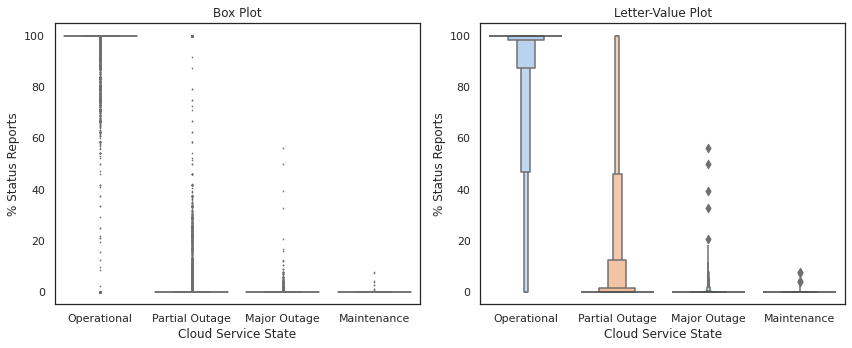

In [10]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set(style='white')
fig, ax = plt.subplots(1,2)
ax1 = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp), ax=ax[0])
ax2 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp), showfliers = True, ax=ax[1])
ax1.set(title='Box Plot', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% Status Reports')
ax2.set(title='Letter-Value Plot', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% Status Reports')
# ax3 = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp_dayhour), ax=ax[1][0])
# ax4 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp_dayhour), showfliers = True, ax=ax[1][1])
# ax3.set(title='Box Plot (Date+Hour Aggregation)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
# ax4.set(title='Letter Value Plot (Date+Hour Aggregation)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
fig.tight_layout()
plt.savefig('/home/shane/Documents/thesis/output/plots/boxes_general.pdf')